In [2]:
import csv
import numpy as np
import pandas as pd
import future

In [3]:
DS = pd.read_csv("DataAnnotatedSubset150SentenceLength.csv")

In [4]:
DS

,text_ID,word,tag
0,46809,RR,object
1,46809,130/80,value
2,46809,mmHg.,NaN
3,47482,"RR142/89mmHg,",object
4,47482,HR,NaN
...,...,...,...
157275,1624218,saamiseks.,NaN
157276,1624218,RR,object
157277,1624218,"140/90,",value
157278,1624218,VS,NaN


In [5]:
DS['tag'].fillna('unk', inplace=True)

In [6]:
data = DS[['text_ID','word','tag']]
data.columns = ['sentence_idx','word','tag']

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [9]:
len(sentences)

13643

In [10]:
# import pickle
# with open('sentences5000.txt', 'wb') as f:
#   pickle.dump(sentences, f)

In [10]:
# with open('sentences2000.txt', 'rb') as f:
#     sentences = pickle.load(f)

In [11]:
LengthsList = []
for i in range(len(sentences)):
    LengthsList.append(len(sentences[i]))

In [14]:
np.median(LengthsList)

10.0

In [15]:
from math import nan

words = list(set(data["word"].values))
n_words = len(words)

tags = []
for tag in set(data["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)

from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [16]:
len(words)

27741

In [17]:
n_tags

3

In [18]:
max([len(s) for s in sentences])

150

In [19]:
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# maxlen = max([len(s) for s in sentences])
maxlen = 150
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["unk"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Using TensorFlow backend.


In [58]:
import pickle
def StoreData(myObject,ObjectName):
        with open(ObjectName+'.txt', 'wb') as f:
          pickle.dump(myObject, f)

In [45]:
StoreData(X_train,"X_train")
StoreData(X_test,"X_test")
StoreData(y_train,"y_train")
StoreData(y_test,"y_test")

In [46]:
# with open('X_test.txt', 'rb') as f:
#     # Step 3
#     X_test = pickle.load(f)

In [20]:
X_train.shape

(10914, 150)

In [78]:
from keras.models import load_model
# def fake_loss(y_true,y_pred):
#         return 0
# def crf_viterbi_accuracy(y_true,y_pred):
#         return 0
from keras_contrib.layers.crf import CRF, crf_loss, crf_viterbi_accuracy
model = load_model('ner-CNN-bi-lstm-model-FULL-0.99.hdf5', custom_objects={'CRF':CRF, 'crf_loss': crf_loss,'crf_viterbi_accuracy': crf_viterbi_accuracy})


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [21]:
from keras.models import Model, Input
from keras.layers import LSTM,MaxPooling1D,Flatten,Embedding, Dense, TimeDistributed, Conv1D,Dropout, Bidirectional
import keras as k
from keras_contrib.layers import CRF

input = Input(shape=(maxlen,))
# word_embedding_size = 150
word_embedding_size = maxlen
# Embedding Layer
model = Embedding(input_dim=n_words, output_dim=word_embedding_size, input_length=maxlen)(input)


# (number of sentences,  words, 100 output dimension or filters)   
# 495,19352,150
# batchSize = number of sentences    
# length = number of words in each sentence   
# channels = dimension of the embedding's output.  
# (19352,495)
model = Conv1D(filters=maxlen,
              kernel_size= 3,  # 3 means 3 words
              padding='same',  # valid means no padding
              strides=1,  # see explnation above
              activation='relu',
              use_bias=True)(model)

# model = MaxPooling1D(pool_size=2)(model) # (?, 27, 10), (?, 24, 10)
# model = Flatten()(model) # (?, 270), (?, 240)
        
        
# BI-LSTM Layer
model = Bidirectional(LSTM(units=word_embedding_size, 
                           return_sequences=True, 
                           dropout=0.5, 
                           recurrent_dropout=0.5, 
                           kernel_initializer=k.initializers.he_normal()))(model)

model = LSTM(units=word_embedding_size * 2, 
             return_sequences=True, 
             dropout=0.5, 
             recurrent_dropout=0.5, 
             kernel_initializer=k.initializers.he_normal())(model)

# TimeDistributed Layer
model = TimeDistributed(Dense(n_tags, activation="relu"))(model)  

# CRF Layer
crf = CRF(n_tags)

out = crf(model)  # output
model = Model(input, out)

In [22]:
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

#Optimiser 
adam = k.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

# Compile model
model.compile(optimizer=adam, loss=crf.loss_function, metrics=[crf.accuracy, 'accuracy'])

model.summary()


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\keras_contrib-2.0.8-py3.7.egg\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 150)          4161150   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 150, 150)          67650     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 300)          361200    
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 300)          721200    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 3)            903       
_________________________________________________________________
crf_1 (CRF)                  (None, 150, 3)            27  

In [24]:

# Saving the best model only
filepath="ner-CNN-bi-lstm-model-5000-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Fit the best model
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=10, validation_split=0.1, verbose=1, callbacks=callbacks_list)

Train on 9822 samples, validate on 1092 samples
Epoch 1/10
9822/9822 [==============================] - 439s 45ms/step - loss: 0.0132 - crf_viterbi_accuracy: 0.9948 - accuracy: 0.0050 - val_loss: 0.0176 - val_crf_viterbi_accuracy: 0.9941 - val_accuracy: 0.9941

Epoch 00001: val_accuracy improved from -inf to 0.99413, saving model to ner-CNN-bi-lstm-model-5000-0.99.hdf5
Epoch 2/10
9822/9822 [==============================] - 441s 45ms/step - loss: 0.0129 - crf_viterbi_accuracy: 0.9949 - accuracy: 0.0050 - val_loss: 0.0175 - val_crf_viterbi_accuracy: 0.9940 - val_accuracy: 0.9941

Epoch 00002: val_accuracy improved from 0.99413 to 0.99413, saving model to ner-CNN-bi-lstm-model-5000-0.99.hdf5
Epoch 3/10
9822/9822 [==============================] - 448s 46ms/step - loss: 0.0127 - crf_viterbi_accuracy: 0.9950 - accuracy: 0.0050 - val_loss: 0.0176 - val_crf_viterbi_accuracy: 0.9939 - val_accuracy: 0.9941

Epoch 00003: val_accuracy did not improve from 0.99413
Epoch 4/10
9822/9822 [==========

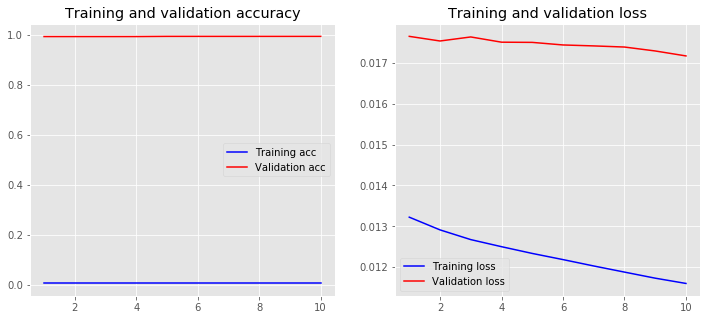

In [25]:
# Plot the graph 
plt.style.use('ggplot')

def plot_history(history):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, 'b', label='Training acc')
    plt.plot(x, val_accuracy, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)


In [26]:
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
test_pred = model.predict(X_test, verbose=1)   
pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

2729/2729 [==============================] - 47s 17ms/step


In [27]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 57.5%


In [28]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      object       0.52      0.86      0.65      2039
         unk       1.00      1.00      1.00    405716
       value       0.00      0.00      0.00      1595

    accuracy                           1.00    409350
   macro avg       0.51      0.62      0.55    409350
weighted avg       0.99      1.00      0.99    409350



In [29]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))
#Reference: https://www.kaggle.com/nikkisharma536/ner-with-bilstm-and-crf/notebook

tag:object
	 TN:         0	FP:         0
	 FN:         0	TP:         0
tag:unk
	 TN:         0	FP:         0
	 FN:         0	TP:    409350
tag:value
	 TN:         0	FP:         0
	 FN:         0	TP:         0


In [30]:
word2idx["RR"]

1863

In [33]:
word2idx["test"]

7057

In [97]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))

i=1000
for w,true, pred in zip(X_test[i], test_labels[i] ,pred_labels[i]):
    print("{:15}: {:5} {}".format(words[w],true,pred))


Word           ||True ||Pred
Kardiovaskulaarsüsteem:: unk   unk
RR             : object object
170/80         : value object
mmHg           : unk   unk
d=s            : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini     : unk   unk
türoksiini 

In [100]:
test_sentence = " Tupp vaba, em.kael puhas, RR 155/85 mmhg , emakas vÃ¤ike, adn.ii."
test_sentence = ''.join(test_sentence).split() 

In [103]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=maxlen)


In [104]:
p = model.predict(np.array([x_test_sent[0]]))
p = np.argmax(p, axis=-1)
print("{:15}||{}".format("Word", "Prediction"))
print(30 * "=")
for w, pred in zip(test_sentence, p[0]):
    print("{:15}: {:5}".format(w, tags[pred]))


Word           ||Prediction
Tupp           : unk  
vaba,          : unk  
em.kael        : unk  
puhas,         : unk  
RR             : object
155/85         : object
mmhg           : unk  
,              : unk  
emakas         : unk  
vÃ¤ike,        : unk  
adn.ii.        : unk  
